In [1]:
import torch
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

In [2]:
import numpy as np

num_dim = 2 # number of different features
num_discrete_values = 8 # number of values that X can take
num_qubits = num_dim * int(np.log2(num_discrete_values))



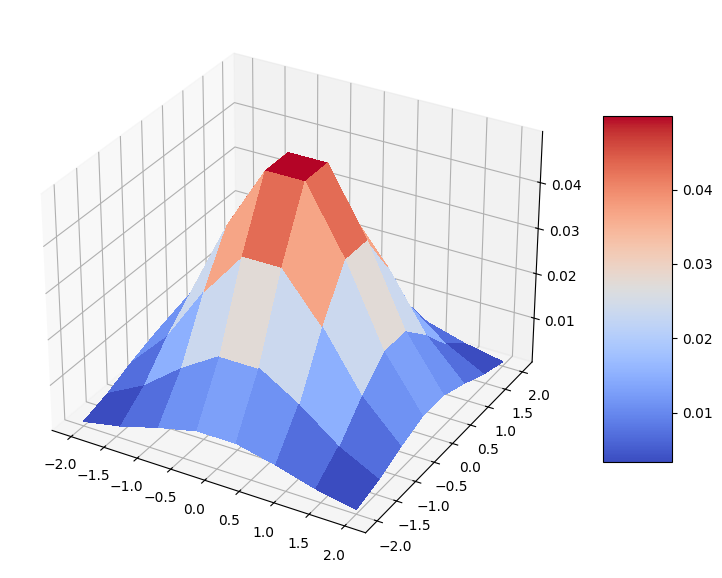

In [3]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Create Generator Circuit

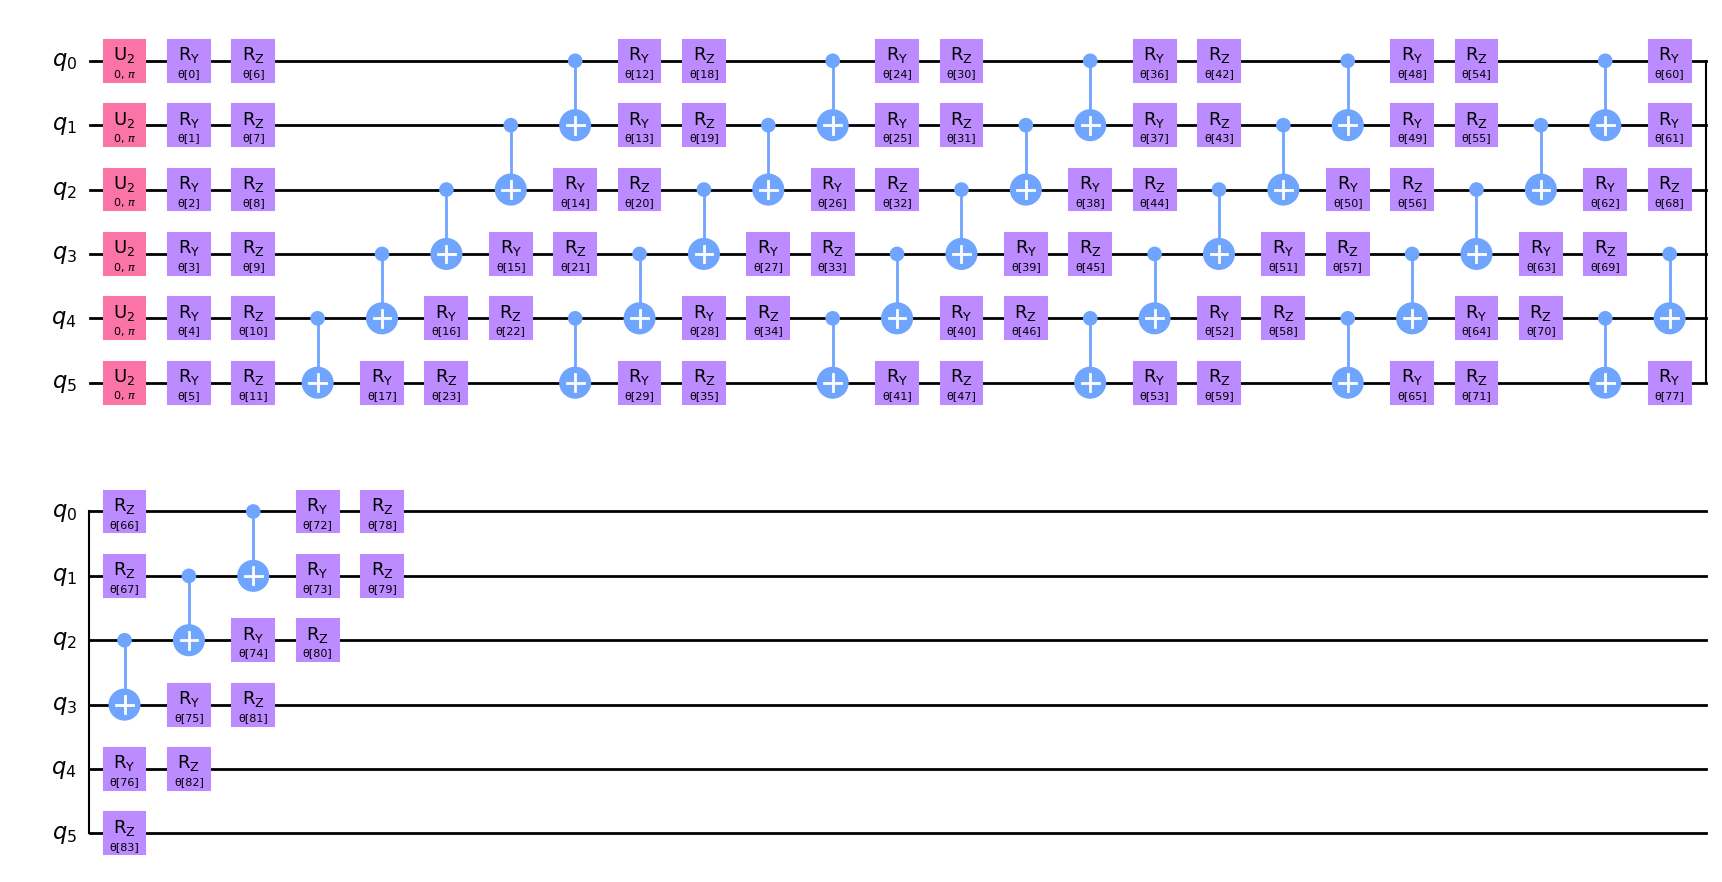

In [4]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

qc.decompose(reps=1).draw('mpl')



In [5]:
qc.num_parameters

84

In [6]:
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})



In [7]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)



# Define Classical Discriminator

In [9]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

# Create Generator and discriminator

In [10]:
generator = create_generator()
discriminator = Discriminator(num_dim)

In [11]:
# gen_dist = generator(torch.tensor([])).reshape(-1, 1)
# print(generator.__dict__)

{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([0.6365, 0.3848, 0.0474, 0.9553, 0.9061, 0.4570, 0.2805, 0.6361, 0.9807,
        0.8124, 0.3052, 0.5680, 0.0207, 0.5731, 0.4122, 0.3453, 0.7305, 0.2817,
        0.0223, 0.2513, 0.2392, 0.6191, 0.7877, 0.2874, 0.3489, 0.8392, 0.0299,
        0.0783, 0.5848, 0.4112, 0.6043, 0.3838, 0.8814, 0.7213, 0.8018, 0.9737,
        0.6352, 0.6321, 0.9441, 0.9725, 0.7389, 0.6489, 0.3806, 0.0023, 0.5865,
        0.7515, 0.3013, 0.8917, 0.8798, 0.1152, 0.5032, 0.5825, 0.8012, 0.4657,
        0.0802, 0.9609, 0.0447, 0.4476, 0.9163, 0.0369, 0.9541, 0.8940, 0.5330,
        0.4777, 0.5212, 0.6503, 0.9550, 0.3821, 0.2840, 0.2353, 0.7735, 0.7747,
        0.9202, 0.9520, 0.3794, 0.1308, 0.2356, 0.4611, 0.1585, 0.8619, 0.8126,
        0.5151, 0.0611, 0.0068], requires_grad=True)), ('_weights', Parameter containing:
tensor([0.6365, 0.3848, 0.0474, 0.9553, 0.9061, 0.4570, 0.2805, 0.6361, 0.9807,
        0.8124, 0.3052, 0.5680

In [12]:
# num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
# print(f"Number of discriminator parameters: {num_params}")

Number of discriminator parameters: 81


# Define Loss

The below part uses binary cross entropy
$$
L(\theta) = \sum_j p_j (\theta)[y_j \log (x_j)+ (1-y_j)\log(1-x_j)]
$$

Since PyTorch’s `binary_cross_entropy` is not differentiable with respect to weights, we implement the loss function manually to be able to evaluate gradients.

In [13]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

# Define Optimizers

In [14]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)


# Training Visualizer

In [15]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

# Train

In [16]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

# print(type(generator))
start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    # plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

<class 'qiskit_machine_learning.connectors.torch_connector.TorchConnector'>
Fit in 23.16 sec


# Results

In [41]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

In [47]:
print(generated_probabilities)

[0.0033 0.0054 0.0045 0.0069 0.0056 0.0035 0.0005 0.0046 0.0007 0.0102
 0.0206 0.0259 0.0002 0.0168 0.0006 0.0011 0.0128 0.0064 0.0028 0.0002
 0.1013 0.0145 0.0072 0.0076 0.0095 0.0057 0.     0.0878 0.071  0.0326
 0.0012 0.0061 0.0295 0.0111 0.0443 0.0544 0.0983 0.0119 0.0034 0.005
 0.0098 0.0323 0.0108 0.0299 0.0138 0.0178 0.0245 0.0072 0.0139 0.0055
 0.0019 0.003  0.0167 0.0261 0.0023 0.0091 0.0016 0.0002 0.0068 0.0087
 0.0037 0.0108 0.0019 0.0067]


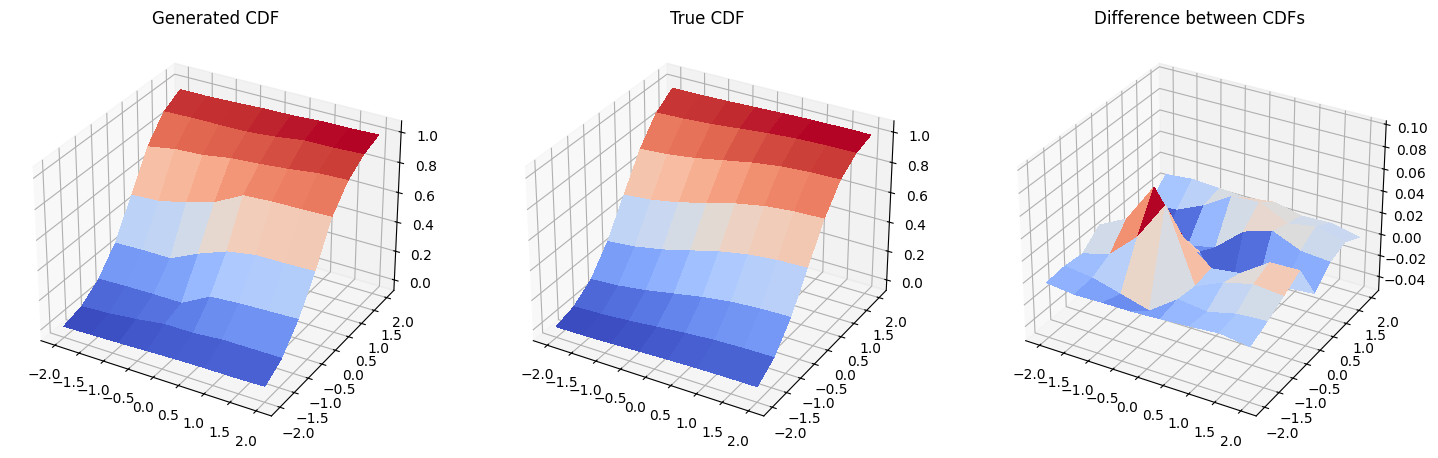

In [42]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()